In [1]:
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled)
Using Theano backend.


In [2]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [3]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [4]:
#path = "../data/dogsandcats_small/" # we copied a fraction of the full set for tests
path = "../data/dogsandcats/"
model_path = path + "models/"
if not os.path.exists(model_path):
    os.mkdir(model_path)
    print('Done')

In [5]:
#??get_file

In [6]:
from vgg16 import Vgg16

In [7]:
batch_size = 100

In [8]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [9]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches('valid', shuffle=False, batch_size=batch_size) # no shuffle as we store conv output
trn_batches = get_batches('train', shuffle=False, batch_size=batch_size) # no shuffle as we store conv output

Found 4000 images belonging to 2 classes.
Found 21000 images belonging to 2 classes.


In [10]:
val_batches.filenames[0:10]

['cat/cat.1262.jpg',
 'cat/cat.9495.jpg',
 'cat/cat.3044.jpg',
 'cat/cat.1424.jpg',
 'cat/cat.8210.jpg',
 'cat/cat.8847.jpg',
 'cat/cat.308.jpg',
 'cat/cat.10802.jpg',
 'cat/cat.5060.jpg',
 'cat/cat.10406.jpg']

In [11]:
val_labels = onehot(val_batches.classes)
trn_labels = onehot(trn_batches.classes)

In [ ]:
'''import hashlib
def modelhash(mdl):
    chaine = str(mdl.to_json())
    return hashlib.md5(chaine).hexdigest()'''
# THE ABOVE FUNCTION DOES NOT WORK DUE TO LAYER DEFAULT NAMES

In [ ]:
try:
    trn = load_array(model_path+'train_data.bc')
except:
    trn = get_data(path+'train')
    save_array(model_path+'train_data.bc', trn)

In [ ]:
try:
    val = load_array(model_path+'valid_data.bc')
except:
    val = get_data(path+'valid')
    save_array(model_path+'valid_data.bc', val)

In [ ]:
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.05, 
                               zoom_range=0.05,
                               #channel_shift_range=10,
                               height_shift_range=0.05, shear_range=0.05, horizontal_flip=False)
trn_batchesRND = gen.flow(trn, trn_labels, batch_size=batch_size)
val_batchesRND = gen.flow(val, val_labels, batch_size=batch_size)

In [14]:
if True:
    realvgg = Vgg16()
    #conv_layers, fc_layers = split_at(realvgg.model, Flatten)
    conv_layers, fc_layers = split_at(realvgg.model, Convolution2D)
    conv_model = Sequential(conv_layers)
    conv_model_hash = 'conv_v5'

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


### Will take a few minutes to complete the 1st time

In [15]:
if True:
    try:
        val_convfeatures = load_array(model_path+'valid_'+conv_model_hash+'_features.bc')
        if False: # force update
            raise
    except:
        print('Missing file')
        val_convfeatures = conv_model.predict_generator(val_batches, val_batches.nb_sample)
        save_array(model_path+'valid_'+conv_model_hash+'_features.bc', val_convfeatures)

### Will take a few minutes (maybe 10) to complete the 1st time

In [16]:
if True:
    try:
        trn_convfeatures = load_array(model_path+'train_'+conv_model_hash+'_features.bc')
        if False: # force update
            raise
    except:
        print('Missing file')
        trn_convfeatures = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
        save_array(model_path+'train_'+conv_model_hash+'_features.bc', trn_convfeatures)

### Fully Convolutional Net : i.e. no dense layers

In [18]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [19]:
def get_fcn_model(nf=128, p=0, withMaxPool=True):
    lrs = [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,1)), # what that (1,1) argument for ??? to handle non square images ???
        Convolution2D(2, 3, 3, border_mode='same'), # 2 factors for cats and dogs
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax') # how does it knows it has 2 outputs ???
    ]
    
    if withMaxPool:
        mdl = Sequential(lrs)
    else: # this is less accurate but it allows to chart finer heatmap
        badtype = type(MaxPooling2D())
        mdl = Sequential([lr for lr in lrs if (type(lr)!=badtype)])
        
    mdl.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return mdl

### Ready to train the model

In [20]:
fcn_model =  get_fcn_model(p=0.40, withMaxPool=True)

In [21]:
fcn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 512, 14, 14)   2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 128, 14, 14)   589952      batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 128, 14, 14)   512         convolution2d_14[0][0]           
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 128, 7, 7)     0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [24]:
fcn_model.optimizer.lr = 1*1e-3
fcn_model.fit(trn_convfeatures, trn_labels, validation_data=(val_convfeatures, val_labels), nb_epoch=1)

Train on 21000 samples, validate on 4000 samples
Epoch 1/1
21000/21000 [==============================] - 33s - loss: 0.0304 - acc: 0.9898 - val_loss: 0.0375 - val_acc: 0.9865


### Plot Feature Heatmap

In [52]:
fcn_heat_model = get_fcn_model(p=0.25, withMaxPool=False)

In [53]:
fcn_heat_model.optimizer.lr = 1*1e-3
fcn_heat_model.fit(trn_convfeatures, trn_labels, validation_data=(val_convfeatures, val_labels), nb_epoch=2)

Train on 21000 samples, validate on 4000 samples
Epoch 1/2
21000/21000 [==============================] - 40s - loss: 0.0747 - acc: 0.9707 - val_loss: 0.0485 - val_acc: 0.9812
Epoch 2/2
21000/21000 [==============================] - 40s - loss: 0.0516 - acc: 0.9795 - val_loss: 0.0426 - val_acc: 0.9828


In [54]:
fcn_heat = K.function([fcn_heat_model.layers[0].input, K.learning_phase()], fcn_heat_model.layers[-4].output)

In [58]:
imarr = trn_batches.next()[0][0]

In [60]:
def showheat(imagearray):
    convfeats = conv_model.predict( np.expand_dims(imagearray,0) )[0]
    label = 0 # as there are 2 labels it does not matter here
    inp = np.expand_dims(convfeats,0) # expand_dims to turn into a 1-element batch
    heat = fcn_heat([inp,0])[0,label]
    heatim = scipy.misc.imresize(heat, (224,224), interp='nearest')
    plt.figure(figsize=(7,7))
    plt.imshow(to_plot(imagearray))
    plt.imshow(heatim, cmap='cool', alpha=0.5)

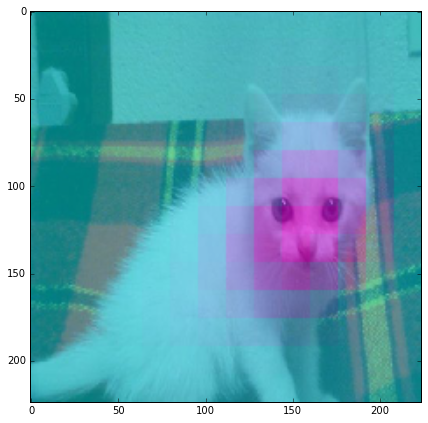

In [59]:
showheat(imarr)

### Next section :  about BatchNorm model conversion, does not apply here

In [ ]:
k_layer_out0 = K.function([dense_model.layers[0].input, K.learning_phase()],
                          [dense_model.layers[0].output])

d0_out = k_layer_out0([trn_convfeatures, 0])[0]

mu0, var0 = d0_out.mean(axis=0), d0_out.var(axis=0)

In [ ]:
k_layer_out2 = K.function([dense_model.layers[0].input, K.learning_phase()],
                          [dense_model.layers[2].output])

d2_out = k_layer_out2([trn_convfeatures, 0])[0]

mu2, var2 = d2_out.mean(axis=0), d2_out.var(axis=0)

In [ ]:
bn_model = insert_layer(dense_model, BatchNormalization(), 1)
bn_model = insert_layer(bn_model, BatchNormalization(), 4) # shifted due to insertion

bnl1 = bn_model.layers[1]
bnl4 = bn_model.layers[4]

#After inserting the layers, we can set their weights to the variance and mean we just calculated.
bnl1.set_weights([var0, mu0, mu0, var0])
bnl4.set_weights([var2, mu2, mu2, var2])

bn_model.compile(Adam(1e-5), 'categorical_crossentropy', ['accuracy'])

In [ ]:
for layer in bn_model.layers:
    print(type(layer), layer.trainable)
    layer.trainable = True

In [ ]:
bn_model.optimizer.lr = 0.01*1e-5
bn_model.fit(trn_convfeatures, trn_labels, validation_data=(val_convfeatures, val_labels), nb_epoch=50)

### Train one or several models (ensembling)

In [ ]:
ll_models = []
for i in range(1): # INFO : change here the size of the ensemble
    ll_models.append( get_fc_model(0) )
    #ll_models[-1].optimizer.lr = 1*1e-5
    ll_models[-1].fit(trn_convfeatures, trn_labels, validation_data=(val_convfeatures, val_labels), nb_epoch=5)

In [ ]:
i = 0

x_conv_model = Sequential(conv_layers)
for layer in x_conv_model.layers:
    layer.trainable = False

for layer in ll_models[i].layers:
    x_conv_model.add(layer)
    
#for l1,l2 in zip(conv_model.layers[last_conv_idx+1:], fc_model.layers): 
#        l1.set_weights(l2.get_weights())
x_conv_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
#x_conv_model.save_weights(model_path+'no_dropout_bn' + i + '.h5')

In [ ]:
for layer in x_conv_model.layers[-5:]:
    layer.trainable = True
x_conv_model.optimizer.lr = 1e-6

In [ ]:
x_conv_model.fit_generator(trn_batchesRND,
                           samples_per_epoch = min(40*batch_size,trn_batchesRND.n),
                           nb_epoch = 1,
                           validation_data = val_batchesRND,
                           nb_val_samples = min(20*batch_size,val_batchesRND.n))

In [ ]:
for mdl in ll_models:
    for k in range(-len(mdl.layers),0):
        print(k)
        #x_conv_model.layers[k].get_weights()
        #mdl.layers[k].set_weights
        mdl.layers[k].set_weights( x_conv_model.layers[k].get_weights() )

In [ ]:
all_val_preds = []
for mdl in ll_models:
    these_val_preds = mdl.predict_on_batch(val_convfeatures)
    assert(len(these_val_preds) == 4000)
    all_val_preds.append( these_val_preds )
mean_val_preds = np.stack(all_val_preds).mean(axis=0)
categorical_accuracy(val_labels, mean_val_preds).eval()

In [ ]:
# WARNING : should save each model of the ensemble
#ll_model.save_weights(model_path+'llmodel_finetune1.h5')
#ll_model.load_weights(model_path+'llmodel_finetune1.h5')

In [12]:
test_batches = get_batches('test', shuffle=False, batch_size=batch_size, class_mode=None)
testfiles = test_batches.filenames
testfiles[0:10]

Found 12500 images belonging to 1 classes.


['test/10592.jpg',
 'test/7217.jpg',
 'test/3653.jpg',
 'test/4382.jpg',
 'test/2924.jpg',
 'test/10.jpg',
 'test/10916.jpg',
 'test/12374.jpg',
 'test/1871.jpg',
 'test/11645.jpg']

### Will take a few minutes (maybe 5) to complete the 1st time

In [17]:
try:
    test_convfeatures = load_array(model_path+'test_'+conv_model_hash+'_features.bc')
    if False: # force update
        raise
except:
    print('Missing file')
    test_convfeatures = conv_model.predict_generator(test_batches, test_batches.nb_sample)
    save_array(model_path+'test_'+conv_model_hash+'_features.bc', test_convfeatures)

In [30]:
test_convfeatures.shape

(12500, 512, 14, 14)

In [45]:
all_test_preds = []
#for mdl in ll_models:
#for mdl in [bn_model]:
for mdl in [fcn_model]:
    chunks = test_convfeatures.shape[0]//1000 + 1 # +1 only if not "round" division
    predchunks = []
    for c in range(chunks): # need to do chunk by chunk due to memory limit
        predchunks.append( mdl.predict_on_batch(test_convfeatures[c*1000:(c+1)*1000,:,:,:]) )
    these_test_preds = np.concatenate(predchunks, axis=0)
    assert(len(these_test_preds) == 12500)
    all_test_preds.append( these_test_preds )
mean_test_preds = np.stack(all_test_preds).mean(axis=0)

In [46]:
len(np.concatenate(predchunks, axis=0)), np.concatenate(predchunks, axis=0).shape, predchunks[0].shape

(12500, (12500, 2), (1000, 2))

In [47]:
mean_test_preds[0:10]

array([[  1.0000e+00,   1.0656e-06],
       [  9.9974e-01,   2.6187e-04],
       [  7.5404e-07,   1.0000e+00],
       [  7.9354e-01,   2.0646e-01],
       [  4.7218e-03,   9.9528e-01],
       [  1.0000e+00,   1.0632e-07],
       [  1.5173e-04,   9.9985e-01],
       [  1.0000e+00,   4.2531e-07],
       [  1.8177e-05,   9.9998e-01],
       [  8.0665e-05,   9.9992e-01]], dtype=float32)

In [48]:
dog_idx = 1
Z1 = [{'id':int(f.split('/')[-1].split('.')[0]), 'label':min(max(round(p[dog_idx],5),0.0001),0.9999)} 
      for f, p in zip(testfiles, mean_test_preds)]
def comp(x,y):
    return int(x['id']) - int(y['id'])
Z1 = sorted(Z1, comp)
Z1[0:18]

[{'id': 1, 'label': 0.9999},
 {'id': 2, 'label': 0.9999},
 {'id': 3, 'label': 0.99946},
 {'id': 4, 'label': 0.9999},
 {'id': 5, 'label': 0.0001},
 {'id': 6, 'label': 0.0001},
 {'id': 7, 'label': 0.0001},
 {'id': 8, 'label': 0.0001},
 {'id': 9, 'label': 0.00167},
 {'id': 10, 'label': 0.0001},
 {'id': 11, 'label': 0.0001},
 {'id': 12, 'label': 0.9999},
 {'id': 13, 'label': 0.0001},
 {'id': 14, 'label': 0.00038},
 {'id': 15, 'label': 0.0001},
 {'id': 16, 'label': 0.00048},
 {'id': 17, 'label': 0.99981},
 {'id': 18, 'label': 0.9999}]

In [51]:
import csv

with open('predictions_v5_1.csv', 'w') as csvfile:
    fieldnames = ['id', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for z in Z1:
        writer.writerow(z)